In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [4]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import urllib
from PIL import Image

In [5]:
PATH = 'data/face/'
image_folder = f'{PATH}train/'
data_csv = PATH+'tw_dem_images.csv'
image_csv = PATH+'image_csv.csv'

model_csv = f'{PATH}current_model_age.csv'

In [6]:
sz=220
# sz=400

### Create Training CSV data from Image CSV

In [14]:
img_df = pd.read_csv(image_csv)

In [15]:
img_df.shape

(58642, 10)

In [ ]:
plt.imshow(plt.imread(img_df.local_photo.iloc[np.random.randint(10)]))

In [ ]:
size_map = { idx:plt.imread(k.local_photo).shape for idx,k in img_df.iterrows()}

In [ ]:
size_map

In [ ]:
h, w, ch = list(zip(*size_map.values()))

In [ ]:
plt.hist(w)

In [ ]:
w = np.array(w)
plt.hist(w[w<600])

In [ ]:
img_df.head()

In [ ]:
temp_df = img_df.loc[~img_df.User_Age.isna() & (img_df.User_Age < 80) & (img_df.User_Age > 20)]
temp_df = pd.DataFrame(data={'id': temp_df.userID, 'age': temp_df.User_Age}, columns=['id', 'age'])
temp_df.to_csv(model_csv, index=False)

In [ ]:
temp_df.sort_values('age')

In [ ]:
temp_df.shape

### Architecture

In [ ]:
# !rm -rf {PATH}tmp

In [7]:
temp_df = pd.read_csv(model_csv)

In [8]:
print(temp_df.age.mean())
print(temp_df.shape)

41.00108256723086
(58195, 2)


In [9]:
arch=resnet50

In [10]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
n = temp_df.shape[0]-1
val_idxs = get_cv_idxs(n)
data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=model_csv, tfms=tfms, suffix='.jpg', val_idxs=val_idxs, continuous=True, bs=64)

In [22]:
new_data = data.resize(sz, PATH+'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [ ]:
# fnames,y,classes = csv_source('train', model_csv, True, '.jpg', continuous=False)

In [ ]:
def show_image(idx):
    x,y = data.trn_ds[idx]
    show_img = data.trn_ds.denorm(x)
    print(show_img.shape)
    print('Y value:', y)
    plt.imshow(show_img[0])

In [ ]:
show_image(3)

In [11]:
# learn = ConvLearner.pretrained(arch, data=data, precompute=True)
learn = ConvLearner.pretrained(arch, data=data)

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [15]:
learn.fit(lrs=1e-2, n_cycle=2,)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      7.744749   7.405819  
    1      7.66692    7.472046                                



[7.4720464]

In [18]:
learn.save('tw_age_face_firstrun1e-2')

In [ ]:
learn.load('tw_age_face_firstrun1e-2')

In [ ]:
learn.precompute=False

In [19]:
learn.fit(lrs=1e-2, n_cycle=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      7.41705    7.240914  
    1      7.496763   7.304375                                
    2      7.359548   7.22035                                 



[7.22035]

In [20]:
learn.save('tw_age_face_run2')

In [12]:
learn.unfreeze()

In [ ]:
learn.lr_find()

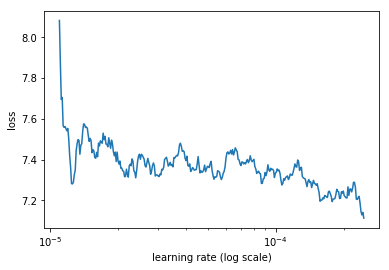

In [23]:
learn.sched.plot()

In [26]:
learn.fit(lrs=[1e-4,1e-3,1e-2], n_cycle=3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))


  0%|          | 0/1455 [00:00<?, ?it/s]                    

Exception in thread Thread-11:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                
    0      5.514927   5.489036  
    1      5.449616   5.226381                                
    2      5.19866    5.082214                                



[5.0822144]

In [27]:
learn.save('tw_age_face_unfreeze1')

In [13]:
learn.load('tw_age_face_unfreeze1')

In [14]:
learn.fit(lrs=[1e-4,1e-3,1e-2], n_cycle=3, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      5.087954   5.189262  
    1      5.027317   5.512411                              
    2      4.789999   5.094199                              
    3      4.591875   5.212185                              
    4      4.538247   5.255004                              
    5      4.462708   5.067485                              
    6      4.508255   5.001145                              



[5.0011454]

In [15]:
learn.save('tw_age_face_unfreeze2_nc3cm2')

In [ ]:
learn.load('tw_age_face_unfreeze2_nc3cm2')

In [ ]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds,y), metrics.log_loss(y, probs)

In [ ]:
preds = np.argmax(log_preds, axis=1)
# np.array(preds==y).mean()
preds
# accuracy(log_preds,y)

### Test image

In [6]:
test_image_url = 'https://images-na.ssl-images-amazon.com/images/M/MV5BMTk4MDM0MDUzM15BMl5BanBnXkFtZTcwOTI4MzU1Mw@@._V1_UY317_CR7,0,214,317_AL_.jpg'

In [83]:
# test_image_file = f'{PATH}test_images/test1.jpg'
# test_image_file = f'{PATH}test_images/kenneth_s.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_2776.jpg'
test_image_file = f'{PATH}test_images/age_img/IMG_8274.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_3135.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_8819.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_9370.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_2793.jpg'
# test_image_file = f'{PATH}test_images/grandma_test1.jpg'
# test_image_file = f'{PATH}test_images/lzl_test1.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_9625.jpg'

# test_image_file = f'{PATH}test_images/jackie_test1.jpg'

In [84]:
# urllib.request.urlretrieve(test_image_url, test_image_file)

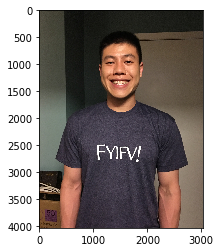

In [85]:
plt.imshow(plt.imread(test_image_file))

In [86]:
val_tfms = tfms[1]

In [87]:
# test_image = val_tfms(plt.imread(test_image_file))
test_image = val_tfms(open_image(test_image_file))


In [88]:
test_image.shape

(3, 220, 220)

In [89]:
eval_mode = learn.model.eval()
# needed so that we know we are in evaluation mode. Otherwise will throw an exception
# equivalent to learn.model.train(False)

In [90]:
age = learn.predict_array([test_image])[0]

In [91]:
print(f'Age:', age[0])

Age: 34.576492


In [ ]:
data.classes

## FIgure out this thing

In [ ]:
trn_tfms = tfms[0]
dl = data.trn_dl

In [ ]:
t = tqdm(iter(data.trn_dl), leave=False, total=len(data.trn_ds)/64)
try:
#     trn_tfms(open_image(test_image_file))
    for a in t:
        pass
except Exception as e:
    print(e)
    print(user_id)
    print(test_image_file)

In [ ]:
first_batch = next(iter(dl))

In [ ]:
first_batch[0][0].shape

In [ ]:
temp_df.head()

In [ ]:
for idx, row in tqdm(temp_df.iterrows(), total=temp_df.shape[0]):
    user_id = int(row.id)
    test_image_file = f'{PATH}train/{user_id}.jpg'
    try:
        trn_tfms(open_image(test_image_file))
    except Exception as e:
        print(e)
        print(user_id)
        print(test_image_file)

In [ ]:
from concurrent.futures import ThreadPoolExecutor, wait, as_completed
def transform_img(user_id):
    test_image_file = f'{PATH}train/{user_id}.jpg'
    try:
        img = open_image(test_image_file)
        trn_tfms(img)
    except Exception as e:
        print(e)
        print(user_id)
        print(test_image_file)

subset_df = temp_df
futures = []
with ProcessPoolExecutor(8) as executor:
    for idx, row in subset_df.iterrows():
        futures.append(executor.submit(transform_img, int(row.id)))

    kwargs = {
        'total': len(futures),
        'unit': 'nap',
        'unit_scale': True,
        'leave': True,
        'disable': False
    }
    for x in tqdm(as_completed(futures), **kwargs):
        pass

In [ ]:
trn_tfms(first_batch[0][0])